# Segmentação
Referências: <br>
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html <br>
https://scikit-image.org/docs/dev/api/skimage.segmentation.html
***

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from skimage.segmentation import felzenszwalb,slic,quickshift,watershed
from skimage.color import rgb2gray
from skimage.filters import sobel

In [34]:
import time 

last_time  = time.time()
#function of time, milliseconds of last tic() 
#reset difine if you want clear the clock for ne next tic()
def tic(reset = True):
	global last_time
	toc = time.time()
	delta = toc - last_time
	if reset:
		last_time = toc
	return delta*1000

## Funcoes de imshow

In [5]:
#minha funcao para mostrar as imagens
def imshow(im,big=False):
    if big:
        plt.figure(figsize=(20,20))
    else:
        plt.figure()
    if len(im.shape)<3:
        plt.imshow(im, cmap='gray')#As cores ficam zoadas no Jupyter se deixar sem esse parâmetro
    else:
        plt.imshow(im[:,:,::-1]) 
    plt.axis('off')
    plt.show()

In [6]:
#pinta uma matriz de labels com cores diferentes
def pinta_blobs(labels,angle_delta=20):
    #cria imagens
    im_hsv = np.ones((labels.shape[0],labels.shape[1],3)).astype('uint8')*255
    
    #printa usando a mascara
    im_hsv[:,:,0] = (labels*angle_delta)%180

    return cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR)

#pinta uma matriz de labels com a media de cores de im 
def pinta_blobs2(labels,im):
    n_labels = int(labels.max()+1)
    im_out = np.zeros(im.shape)
    
    #divide por canal
    b,g,r    = im[:,:,0],im[:,:,1],im[:,:,2]
    bo,go,ro = im_out[:,:,0],im_out[:,:,1],im_out[:,:,2]
    
    for label in range(n_labels):
        mask = labels==label
        bo[mask] += np.median(b[mask])#b[mask].mean()
        go[mask] += np.median(g[mask])#g[mask].mean()
        ro[mask] += np.median(r[mask])#r[mask].mean()
    return im_out.astype('uint8')

## Abre imagem

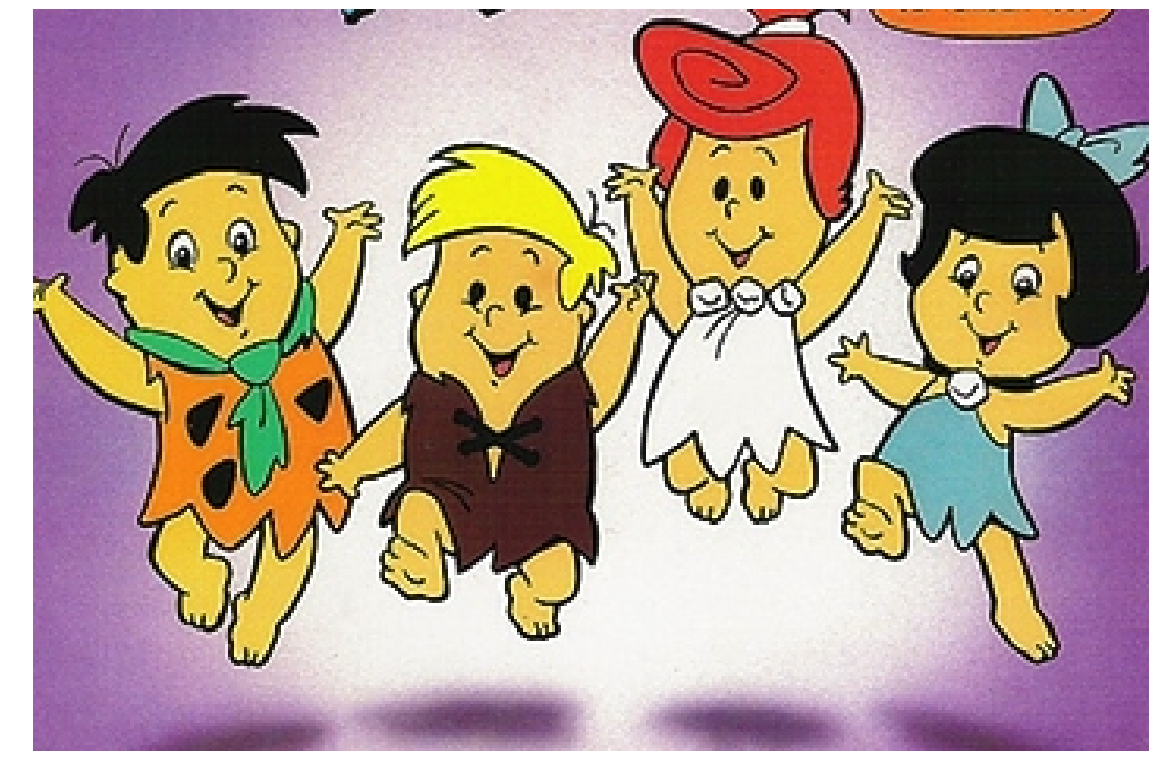

In [30]:
im = cv2.imread('imgs/1.jpg')
imshow(im, True)

***
# 1. Minha Segmentacao
### 1.1 floodfill com distância de cores

In [8]:
#distancia entre a cor de dois pixels em RGB
def dist_cor(pixel1,pixel2):
    #return np.sqrt(((pixel1-pixel2)**2).sum())
    return ((pixel1-pixel2)**2).sum()

In [9]:
#floodfill com pilha
def floodfill(matrix,labels,x0,y0,label,alpha=50):
    size = matrix.shape
    
    pilha = list()
    pilha.append([x0,y0,None])
    
    while(pilha):
        
        x,y,pixel_ant = pilha.pop()
        labels[y,x] = label
        
        # Se as cores forem parecidas
        if pixel_ant is None or dist_cor(matrix[y,x],pixel_ant) <= alpha:
            #recursivo para os vizinhos
            if x > 0 and labels[y,x-1]<0:
                pilha.append([x-1,y,matrix[y,x]])
            if x < size[1] - 1 and labels[y,x+1]<0:
                pilha.append([x+1,y,matrix[y,x]])
            if y > 0 and labels[y-1,x]<0:
                pilha.append([x,y-1,matrix[y,x]])
            if y < size[0] - 1 and labels[y+1,x]<0:
                pilha.append([x,y+1,matrix[y,x]])

In [10]:
def meu_segmenta(im):
    labels = np.ones((im.shape[0],im.shape[1])).astype(int)*-1
    label = 0
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if labels[y,x]==-1:
                floodfill(im,labels,x,y,label)
                label+=1
    print(label)
    return labels

In [11]:
%%time
labels = meu_segmenta(im)

11361
CPU times: user 874 ms, sys: 1.94 ms, total: 876 ms
Wall time: 880 ms


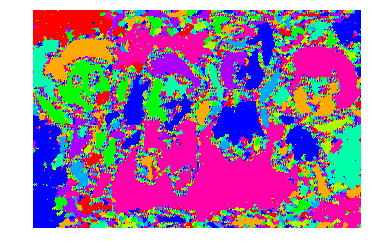

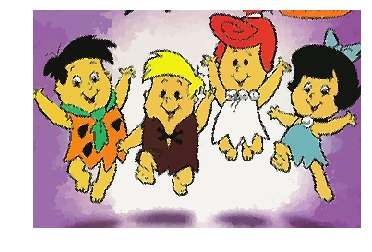

In [12]:
imshow(pinta_blobs(labels))
imshow(pinta_blobs2(labels,im))

### 1.2 

In [13]:
#matriz de adjacência dos blobs
def matriz_adj(labels,viz8=False):
    #cria matriz
    size = int(labels.max()+1)
    adj = np.identity(size+1).astype(int)
    
    #labels com borda (para evitar de olhar limites nas vizinhanças)
    labels2 = np.ones(np.array(labels.shape)+2).astype(int)*size
    labels2[1:-1,1:-1] = labels
    
    for y in range(1,labels.shape[0]+1):
        for x in range(1,labels.shape[1]+1):
            adj[labels2[y,x],labels2[y,x-1]]+=1
            adj[labels2[y,x],labels2[y,x+1]]+=1
            adj[labels2[y,x],labels2[y-1,x]]+=1
            adj[labels2[y,x],labels2[y+1,x]]+=1
            if viz8:
                adj[labels2[y,x],labels2[y-1,x-1]]+=1
                adj[labels2[y,x],labels2[y-1,x+1]]+=1
                adj[labels2[y,x],labels2[y+1,x-1]]+=1
                adj[labels2[y,x],labels2[y+1,x+1]]+=1
                
    # retira vertices das bordas
    adj = adj[:-1,:-1]
    return adj
#matriz_adj(labels)

In [14]:
#cor mediana de cada blob
def mediana_blobs(labels,im):
    n_labels = int(labels.max()+1)
    
    cores = np.zeros((n_labels,3)).astype(int)
    
    #divide os canais
    b,g,r    = im[:,:,0],im[:,:,1],im[:,:,2]
    
    for l in range(n_labels):
        mask = labels==l
        cores[l,0] = np.median(b[mask])#b[mask].mean()
        cores[l,1] = np.median(g[mask])#g[mask].mean()
        cores[l,2] = np.median(r[mask])#r[mask].mean()
    return cores
#mediana_blobs(labels,im)

In [50]:
# dado dois blobs de label l1 e l2
# junta os dois e arruma a matriz de adjacência
def junta_blobs(l1,l2,labels,adj,lista_pais):
    labels = labels.copy()
    
    l2_vivo = lista_pais[l2]
    
    #arruma matriz labels
    labels[labels==l2] = l1
    labels[labels>l2] -= 1
    
    adj[l1,:] += adj[l2,:]
    adj[:,l1] += adj[:,l2]
    adj[l1,l1] -= 1
    
    tic()
    
    #adj=np.delete(adj, l2, 0)
    #adj=np.delete(adj, l2, 1)
    
    print('d: ' + str(tic()))
    
    return labels,adj

In [51]:
def agrupa(im,labels,dist_cor_min=30,conexos_min=1):
    labels = labels.copy()
    
    adj = matriz_adj(labels)
    cores = mediana_blobs(labels,im)
    n_labels = cores.shape[0]
    lista_pais = np.arange(n_labels)
    n_labels_ant = n_labels+1
    
    #enquando conseguir diminuir o numero de labels
    while(n_labels_ant>n_labels):
        n_labels_ant = n_labels
        
        #para cada par de labels
        l1=0
        while(l1<n_labels):
            print(l1,'/',n_labels)
            l2 = l1+1
            while(l2<n_labels):
                if dist_cor(cores[l1],cores[l2])<=dist_cor_min and adj[l1,l2]>=conexos_min:
                    labels,adj = junta_blobs(l1,l2,labels,adj,lista_pais)
                    n_labels-=1
                elif l1 == 5:
                    return labels
                else:
                    l2+=1
            l1+=1
        
        #novo vetor de cores
        cores = mediana_blobs(labels,im)
        n_labels = cores.shape[0]
        
        print(n_labels_ant,'para',n_labels,'blobs')
    return labels

In [52]:
%%time
labels = meu_segmenta(im)
labels = agrupa(im,labels)

11361
0 / 11361
começo: 101421.94986343384
b: 0.9124279022216797
c: 0.9388923645019531
d: 916.9445037841797
começo: 34.37685966491699
b: 0.7224082946777344
c: 1.1196136474609375
d: 942.3136711120605
começo: 32.65714645385742
b: 0.5950927734375
c: 1.1219978332519531
d: 952.5966644287109
começo: 32.25827217102051
b: 0.9031295776367188
c: 1.0828971862792969
d: 937.4306201934814
1 / 11357
2 / 11357
3 / 11357
4 / 11357
começo: 229.66814041137695
b: 0.8308887481689453
c: 0.9999275207519531
d: 950.2191543579102
começo: 32.007455825805664
b: 0.7500648498535156
c: 0.972747802734375
d: 942.3410892486572
5 / 11355
CPU times: user 5.13 s, sys: 4.36 s, total: 9.5 s
Wall time: 9.55 s


***
# 2. felzenszwalb

In [23]:
%%time
#segments_fz = felzenszwalb(im, scale=100, sigma=0.5, min_size=50)
segments_fz = felzenszwalb(im, scale=100, sigma=0.5, min_size=3)

CPU times: user 121 ms, sys: 22.4 ms, total: 143 ms
Wall time: 143 ms


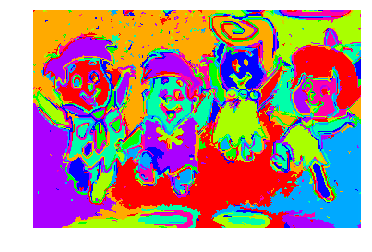

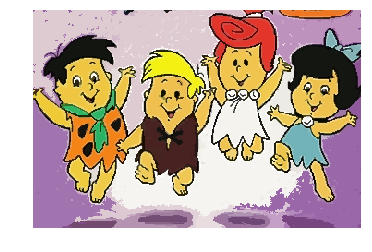

In [24]:
imshow(pinta_blobs(segments_fz))
imshow(pinta_blobs2(segments_fz,im))

***
# 3. Slic

In [25]:
%%time
#segments_slic = slic(im, n_segments=250, compactness=10, sigma=1)
segments_slic = slic(im, n_segments=250, compactness=10, sigma=1)

CPU times: user 111 ms, sys: 783 µs, total: 112 ms
Wall time: 111 ms


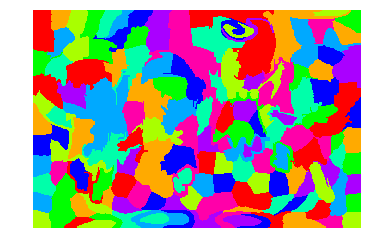

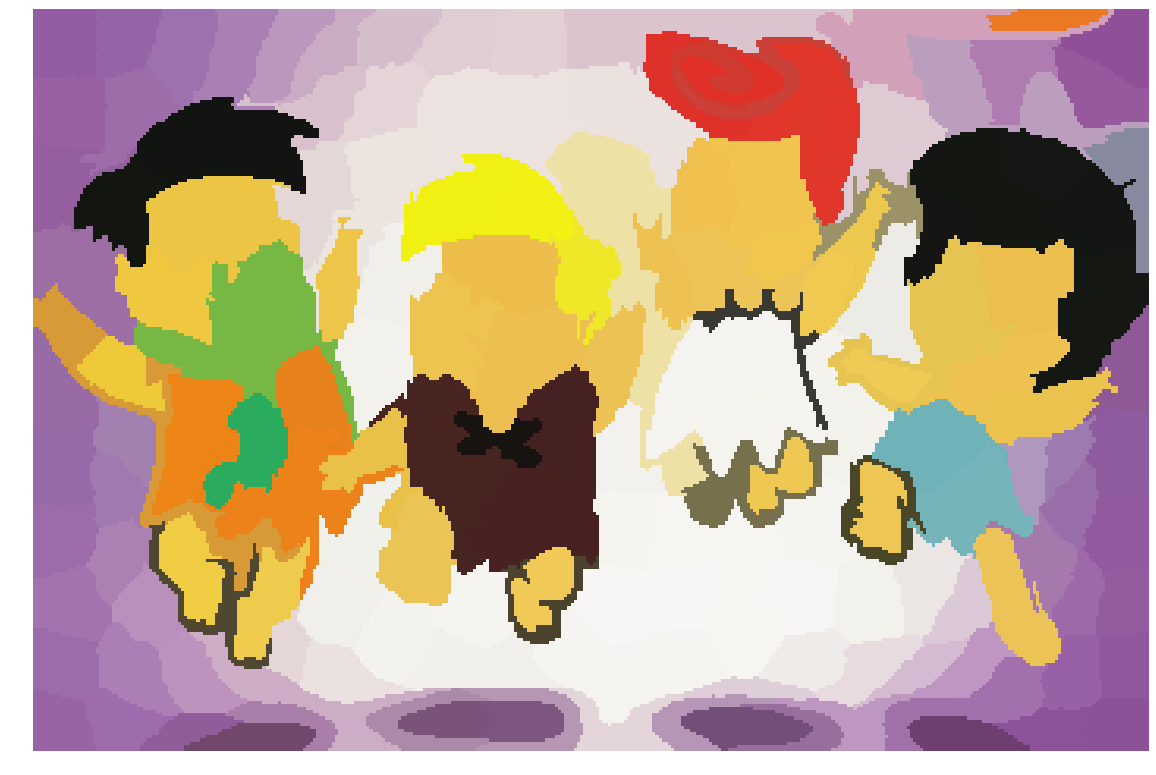

In [58]:
imshow(pinta_blobs(segments_slic))
imshow(pinta_blobs2(segments_slic,im), True)

***
# 4. quickshift

In [27]:
%%time
#segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
segments_quick = quickshift(im, kernel_size=3, max_dist=6, ratio=0.5)

CPU times: user 617 ms, sys: 2.78 ms, total: 620 ms
Wall time: 620 ms


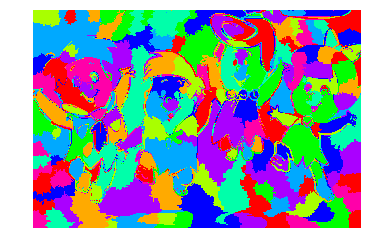

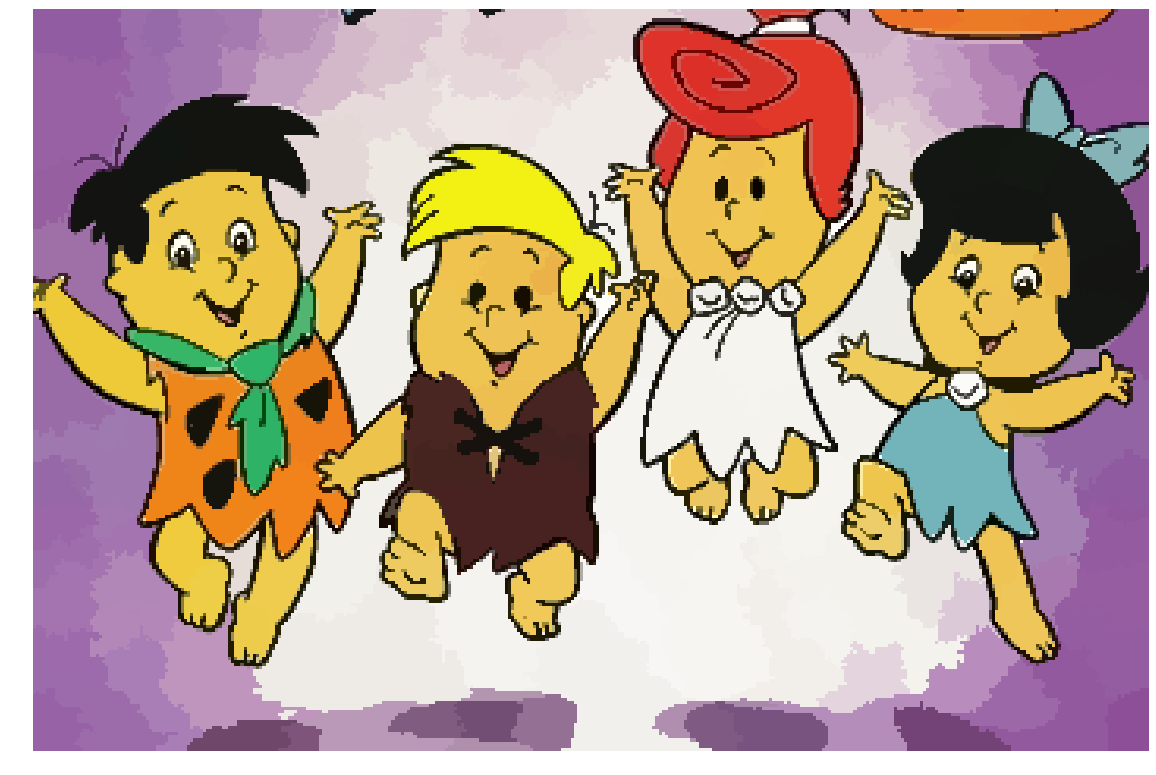

In [29]:
imshow(pinta_blobs(segments_quick))
imshow(pinta_blobs2(segments_quick,im),True)

***
# 5. Watershed

In [31]:
%%time
gradient = sobel(rgb2gray(im))
#segments_watershed = watershed(gradient, markers=250, compactness=0.001)
segments_watershed = watershed(gradient, markers=2000, compactness=0)

CPU times: user 34.6 ms, sys: 554 µs, total: 35.1 ms
Wall time: 34.5 ms


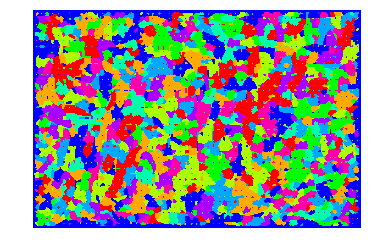

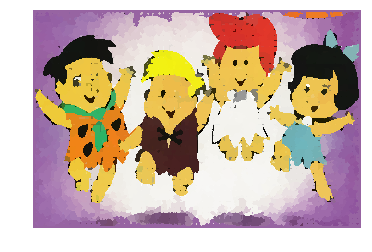

In [33]:
imshow(pinta_blobs(segments_watershed))
imshow(pinta_blobs2(segments_watershed,im))